# Bidirectional RNN with LSTM/GRU cells Classifier for Twitter Covid Vaccination Data

**GPU info**

To get the same results (best ones) you should have a Tesla T4 GPU. Because google colab does not give you the same GPU every time, you must keep closing and re-opening sessions until you get a Tesla T4 GPU like the one below.

In [1]:
!nvidia-smi

Sun Jan 30 16:38:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Mount Google Drive(to read the datasets)**

We will first mount the google drive storage to load the datasets. It is not necessary, but I did it this way in order to avoid uploading them every time. If you want, you can upload yours and just change the import paths. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import necessary libraries**

Then, we will import the necessary libraries


In [2]:
import pandas as pd
import re
import random
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from enum import Enum
from torchtext.legacy import data
from torchtext.vocab import GloVe
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve, auc

pd.set_option('max_colwidth', 500)
%matplotlib inline

**Enable CUDA**

Enable CUDA for GPU utilization by our model. This makes calculations and thus the training of our models faster.

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Set random seed**

Set a constant random seed in order to get the same (deterministic) outputs every time we run our models.

In [4]:
seed = 17064
def reset_seed():
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
reset_seed()

# Dataset loading
Now, let's load our datasets:

**Train Dataset**

In [5]:
train_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_train.csv')
train_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
train_dataset

,tweet,label
0,Sip N Shop Come thru right now #Marjais #PopularNobodies #MMR 🙌🙌🙌🙌 @ Marjais SipNShop http://t.co/JfWAH7uzWE,0
1,I don't know about you but My family and I will not take the #Covid19 vaccine anytime soon...,1
2,"@MSignorile Immunizations should be mandatory. Period. In Oklahoma, they won't let kids go to school without them. It's dangerous otherwise!",2
3,"President Obama spoke in favor of vaccination for children. Fox will start telling its viewers to ""choose"" against vaccination in 3,2,1...",0
4,"""@myfoxla: Arizona monitoring hundreds for measles linked to Disneyland http://t.co/tEoU2zAQat"" It's a Small World After All.",0
...,...,...
15971,@Salon if u believe the anti-vax nutcases caused measles u are ignoring the Obama illegal children who streamed to the US. coincidence?,1
15972,How do you feel about parents who don't #vaccinate their kids?\r\nhttps://t.co/k3O7Al8Au3\r\n#MeaslesOutbreak,0
15973,70 Preschoolers Tested for Measles in Simi Valley http://t.co/pTRjYu8SVr,0
15974,"Finance Minister: Budget offers room to procure COVID-19 vaccines, if available https://t.co/VLdKXat3NJ",0


**Validation Dataset**

In [6]:
validation_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_dev.csv')
validation_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
validation_dataset

,tweet,label
0,"@user They had a massive surge in with covid deaths immediately after the vaccine rollout, way more than they had during the entirety of the ""pandemic"" up to that point. Fuck those jabs, Dr.Death.",1
1,Required vaccines for school: Parents and guardians of children with school exclusion letters now have an... http://t.co/KVl8Dt86dz,0
2,“@KCStar: Two more Johnson County children have measles http://t.co/Rvx07sc” @sethmnookin,0
3,"NV can do better. Which states are the best (and worst) at vaccinating their kids http://t.co/6GaZGgYA9z http://t.co/pTFRJZ2Tmr""",2
4,Nothing like killing ourselves w/ our own fear MT@Alyssa_Milano: Vaccine fears have fueled the resurgence of preventable diseases.,2
...,...,...
2277,"RT @abc7: Number of measles cases reported in Cali is at a 10-year high, officials say http://t.co/J4tqBkJl uggh not a good thing at all!!",0
2278,"Evidence points to the idea that ""measles affects the immune system for two to three years"" after the disease. http://t.co/DbjIQVLQrS",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you should vaccinate your kids, in two minutes: http://t.co/HrZPqQERkY""",2
2280,"Some of my favorite people have autism. If that's your reason for bringing back diseases we have eviscerated, fuck you. #vaccineswork",2


**Test Dataset**

Note: I used the same dataset as the validation, because the assignment's test set was hidden. You can plug your own just by changing the path.

In [7]:
test_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_dev.csv')
test_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
test_dataset

,tweet,label
0,"@user They had a massive surge in with covid deaths immediately after the vaccine rollout, way more than they had during the entirety of the ""pandemic"" up to that point. Fuck those jabs, Dr.Death.",1
1,Required vaccines for school: Parents and guardians of children with school exclusion letters now have an... http://t.co/KVl8Dt86dz,0
2,“@KCStar: Two more Johnson County children have measles http://t.co/Rvx07sc” @sethmnookin,0
3,"NV can do better. Which states are the best (and worst) at vaccinating their kids http://t.co/6GaZGgYA9z http://t.co/pTFRJZ2Tmr""",2
4,Nothing like killing ourselves w/ our own fear MT@Alyssa_Milano: Vaccine fears have fueled the resurgence of preventable diseases.,2
...,...,...
2277,"RT @abc7: Number of measles cases reported in Cali is at a 10-year high, officials say http://t.co/J4tqBkJl uggh not a good thing at all!!",0
2278,"Evidence points to the idea that ""measles affects the immune system for two to three years"" after the disease. http://t.co/DbjIQVLQrS",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you should vaccinate your kids, in two minutes: http://t.co/HrZPqQERkY""",2
2280,"Some of my favorite people have autism. If that's your reason for bringing back diseases we have eviscerated, fuck you. #vaccineswork",2


# Text Preprocessing
Now, we will clean our tweets from useless information in order to make a good vectorization later. More specifically, we will remove tags, urls. html symbols like &amp, punctuation (except ' and ’ because we will need them to remove stopwords like it's), underscore(_) characters, whitespace, single characters, numbers, and we will convert the texts to lowercase because all words are the same in both upper and lower cases. Note that we will keep the hashtags(without the # symbol), because they contain useful information about the tweets.

In [8]:
def text_preprocessing(text: str):
  # Remove tags
  text = re.sub(r'@\s?\w+',' ',text)
  # Remove urls
  text = re.sub(r'https?://\S+',' ',text)
  # Remove html symbols
  text = re.sub(r'&\w+', '', text)
  # Replace ’ with '
  text = re.sub(r'’','\'', text)
  # Remove punctuation(except ' and ’)
  text = re.sub(r'[^’\'\s\w]',' ',text)
  # Remove underscore characters
  text = re.sub(r'_', ' ', text)
  # Remove \r and \n
  text = re.sub(r'[\r\n]',' ', text)
  # Remove single characters
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ',text)
  # Remove single characters from start
  text = re.sub(r'^[a-zA-Z]\s+', '', text)
  # Remove single characters from end
  text = re.sub(r'\s+[a-zA-Z]$', '', text)
  # Remove numbers
  text = re.sub(r'\d+','',text)
  # Remove single ' and 's
  text = re.sub(r'\'s?', '', text)
  # Convert multiple spaces to single space and remove beginning and end spaces
  text = re.sub(r' +',' ',text).strip()
  # Convert to lowercase
  text = text.lower()

  return text

**Train Dataset**

In [9]:
train_dataset['tweet'] = train_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
train_dataset

,tweet,label
0,sip shop come thru right now marjais popularnobodies mmr sipnshop,0
1,dont know about you but my family and will not take the covid vaccine anytime soon,1
2,immunizations should be mandatory period in oklahoma they wont let kids go to school without them it dangerous otherwise,2
3,president obama spoke in favor of vaccination for children fox will start telling its viewers to choose against vaccination in,0
4,arizona monitoring hundreds for measles linked to disneyland it small world after all,0
...,...,...
15971,if believe the anti vax nutcases caused measles are ignoring the obama illegal children who streamed to the us coincidence,1
15972,how do you feel about parents who dont vaccinate their kids measlesoutbreak,0
15973,preschoolers tested for measles in simi valley,0
15974,finance minister budget offers room to procure covid vaccines if available,0


**Validation Dataset**

In [10]:
validation_dataset['tweet'] = validation_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
validation_dataset

,tweet,label
0,they had massive surge in with covid deaths immediately after the vaccine rollout way more than they had during the entirety of the pandemic up to that point fuck those jabs dr death,1
1,required vaccines for school parents and guardians of children with school exclusion letters now have an,0
2,two more johnson county children have measles,0
3,nv can do better which states are the best and worst at vaccinating their kids,2
4,nothing like killing ourselves our own fear mt vaccine fears have fueled the resurgence of preventable diseases,2
...,...,...
2277,rt number of measles cases reported in cali is at year high officials say uggh not good thing at all,0
2278,evidence points to the idea that measles affects the immune system for two to three years after the disease,0
2279,where why you should vaccinate your kids in two minutes,2
2280,some of my favorite people have autism if that your reason for bringing back diseases we have eviscerated fuck you vaccineswork,2


**Test Dataset**

In [11]:
test_dataset['tweet'] = test_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
test_dataset

,tweet,label
0,they had massive surge in with covid deaths immediately after the vaccine rollout way more than they had during the entirety of the pandemic up to that point fuck those jabs dr death,1
1,required vaccines for school parents and guardians of children with school exclusion letters now have an,0
2,two more johnson county children have measles,0
3,nv can do better which states are the best and worst at vaccinating their kids,2
4,nothing like killing ourselves our own fear mt vaccine fears have fueled the resurgence of preventable diseases,2
...,...,...
2277,rt number of measles cases reported in cali is at year high officials say uggh not good thing at all,0
2278,evidence points to the idea that measles affects the immune system for two to three years after the disease,0
2279,where why you should vaccinate your kids in two minutes,2
2280,some of my favorite people have autism if that your reason for bringing back diseases we have eviscerated fuck you vaccineswork,2


# Stopwords Removal
Now, we will remove some stopwords(words that do not have any important value for the texts) from all the tweets. However, this time we will keep some stopwords like "not" because they are sometimes useful in the context of a tweet. For example, in the 2nd training sample "don't know about you but my family and will **not** take the covid vaccine anytime soon" the word **not** is the one that makes this tweet anti-vax, and without it (my family will take the covid vaccine...) it would be pro-vax.

First, let's download the stopwords that we are going to remove:

In [12]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
print(len(STOPWORDS))
STOPWORDS.remove('no')
STOPWORDS.remove('nor')
STOPWORDS.remove('not')
STOPWORDS.remove('don\'t')
STOPWORDS.remove('don')
STOPWORDS.remove('aren\'t')
STOPWORDS.remove('aren')
STOPWORDS.remove('couldn')
STOPWORDS.remove('couldn\'t')
STOPWORDS.remove('didn')
STOPWORDS.remove('didn\'t')
STOPWORDS.remove('doesn')
STOPWORDS.remove('doesn\'t')
STOPWORDS.remove('hadn')
STOPWORDS.remove('hadn\'t')
STOPWORDS.remove('hasn')
STOPWORDS.remove('hasn\'t')
STOPWORDS.remove('haven')
STOPWORDS.remove('haven\'t')
STOPWORDS.remove('isn')
STOPWORDS.remove('isn\'t')
STOPWORDS.remove('mightn')
STOPWORDS.remove('mightn\'t')
STOPWORDS.remove('mustn')
STOPWORDS.remove('mustn\'t')
STOPWORDS.remove('needn')
STOPWORDS.remove('needn\'t')
STOPWORDS.remove('shan')
STOPWORDS.remove('shan\'t')
STOPWORDS.remove('shouldn')
STOPWORDS.remove('shouldn\'t')
STOPWORDS.remove('wasn')
STOPWORDS.remove('wasn\'t')
STOPWORDS.remove('weren')
STOPWORDS.remove('weren\'t')
STOPWORDS.remove('won')
STOPWORDS.remove('won\'t')
STOPWORDS.remove('wouldn')
STOPWORDS.remove('wouldn\'t')
print(len(STOPWORDS))
print(STOPWORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
179
140
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

Then, let's remove them from our datasets:

In [13]:
def remove_stopwords(text):
  tokens = text.split(' ')
  return ' '.join([w for w in tokens if w not in STOPWORDS])

In [14]:
train_dataset['tweet'] = train_dataset['tweet'].apply(remove_stopwords)
train_dataset

,tweet,label
0,sip shop come thru right marjais popularnobodies mmr sipnshop,0
1,dont know family not take covid vaccine anytime soon,1
2,immunizations mandatory period oklahoma wont let kids go school without dangerous otherwise,2
3,president obama spoke favor vaccination children fox start telling viewers choose vaccination,0
4,arizona monitoring hundreds measles linked disneyland small world,0
...,...,...
15971,believe anti vax nutcases caused measles ignoring obama illegal children streamed us coincidence,1
15972,feel parents dont vaccinate kids measlesoutbreak,0
15973,preschoolers tested measles simi valley,0
15974,finance minister budget offers room procure covid vaccines available,0


In [15]:
validation_dataset['tweet'] = validation_dataset['tweet'].apply(remove_stopwords)
validation_dataset

,tweet,label
0,massive surge covid deaths immediately vaccine rollout way entirety pandemic point fuck jabs dr death,1
1,required vaccines school parents guardians children school exclusion letters,0
2,two johnson county children measles,0
3,nv better states best worst vaccinating kids,2
4,nothing like killing fear mt vaccine fears fueled resurgence preventable diseases,2
...,...,...
2277,rt number measles cases reported cali year high officials say uggh not good thing,0
2278,evidence points idea measles affects immune system two three years disease,0
2279,vaccinate kids two minutes,2
2280,favorite people autism reason bringing back diseases eviscerated fuck vaccineswork,2


In [16]:
test_dataset['tweet'] = test_dataset['tweet'].apply(remove_stopwords)
test_dataset

,tweet,label
0,massive surge covid deaths immediately vaccine rollout way entirety pandemic point fuck jabs dr death,1
1,required vaccines school parents guardians children school exclusion letters,0
2,two johnson county children measles,0
3,nv better states best worst vaccinating kids,2
4,nothing like killing fear mt vaccine fears fueled resurgence preventable diseases,2
...,...,...
2277,rt number measles cases reported cali year high officials say uggh not good thing,0
2278,evidence points idea measles affects immune system two three years disease,0
2279,vaccinate kids two minutes,2
2280,favorite people autism reason bringing back diseases eviscerated fuck vaccineswork,2


# Data preparation

Now, we will prepare out data(tweets) in order to work with outr RNNs.


**Download GloVe pre-trained word embeddings**

First, we will download pre-trained word embeddings from GloVe to use as our word-embeddings. We will use the same embeddings as in the previous assignment:

In [17]:
glove = GloVe(name="6B", dim=300)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.30MB/s]                           
100%|█████████▉| 399999/400000 [00:37<00:00, 10703.95it/s]


**Drop tweets with unknown words from training set**

We will also drop tweets from the training set that their words do not belong to any of our pre-trained word embeddings. The reason for this is because they produce noise which is bad for the training of our model.

In [18]:
def drop_with_unknown_words(row):
  known = False
  for word in row['tweet'].split():
    if word in glove.stoi.keys():
      known = True
  return known

In [19]:
train_dataset = train_dataset[train_dataset.apply(drop_with_unknown_words, axis=1)]
train_dataset

,tweet,label
0,sip shop come thru right marjais popularnobodies mmr sipnshop,0
1,dont know family not take covid vaccine anytime soon,1
2,immunizations mandatory period oklahoma wont let kids go school without dangerous otherwise,2
3,president obama spoke favor vaccination children fox start telling viewers choose vaccination,0
4,arizona monitoring hundreds measles linked disneyland small world,0
...,...,...
15971,believe anti vax nutcases caused measles ignoring obama illegal children streamed us coincidence,1
15972,feel parents dont vaccinate kids measlesoutbreak,0
15973,preschoolers tested measles simi valley,0
15974,finance minister budget offers room procure covid vaccines available,0


**Export preprocessed datasets to csv**

We also need to export our pre-processed datasets to new csv files because we will need them later.

In [20]:
train_dataset[['tweet', 'label']].to_csv("train_final.csv")
validation_dataset[['tweet', 'label']].to_csv("validation_final.csv")
test_dataset[['tweet', 'label']].to_csv("test_final.csv")

**Load pre-processed datasets using torchtext**

Defining the felds:

In [21]:
tweet_field = data.Field(sequential=True, batch_first=True, lower=True, fix_length=40)
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True)

fields = {"tweet": ("t", tweet_field), "label": ("l", label_field)}

Defining the datasets:

In [22]:
train_data, validation_data, test_data = data.TabularDataset.splits(path="", train="train_final.csv", validation="validation_final.csv", test="test_final.csv", format="csv", fields=fields)

Creating the vocabulary:

In [23]:
tweet_field.build_vocab(train_data, vectors=glove, min_freq=1)

In [24]:
len(tweet_field.vocab)

18266

# General model definition

We will now define the general model class for all the models we will experiment with.

In [62]:
class CellType(Enum):
  LSTM=1
  GRU=2

class MyRNN(nn.Module):
  def __init__(self, cell_type: CellType, num_embeddings: int, embeddings: torch.Tensor, embed_size: int, hidden_size: int, num_layers: int, dropout=0, skip_connections=False, attention=False):
    super(MyRNN, self).__init__()

    # Copy attributes to model
    self.cell_type = cell_type
    self.num_embeddings = num_embeddings
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = dropout
    self.skip_connections = skip_connections
    self.attention = attention

    # Initialize embedding layer with given(glove) weights
    self.embedding = nn.Embedding(self.num_embeddings, self.embed_size, device=device)
    self.embedding.weight.data.copy_(embeddings)

    # Disable embedding gradients in order not to be trained further.
    self.embedding.weight.requires_grad = False
    
    # Initialize cells
    self.cells_forward = []
    self.cells_backward = []

    for i in range(self.num_layers):
      if self.cell_type == CellType.LSTM:
        self.cells_forward.append(nn.LSTM(input_size=self.embed_size if i == 0 else self.hidden_size, hidden_size=self.hidden_size, num_layers=1, batch_first=True, bidirectional=False, device=device))
        self.cells_backward.append(nn.LSTM(input_size=self.embed_size if i == 0 else self.hidden_size, hidden_size=self.hidden_size, num_layers=1, batch_first=True, bidirectional=False, device=device))
      elif self.cell_type == CellType.GRU:
        self.cells_forward.append(nn.GRU(input_size=self.embed_size if i == 0 else self.hidden_size, hidden_size=self.hidden_size, num_layers=1, batch_first=True, bidirectional=False, device=device))
        self.cells_backward.append(nn.GRU(input_size=self.embed_size if i == 0 else self.hidden_size, hidden_size=self.hidden_size, num_layers=1, batch_first=True, bidirectional=False, device=device))

    self.cells_forward = nn.ModuleList(self.cells_forward)
    self.cells_backward = nn.ModuleList(self.cells_backward)

    # Initialize a dropout layer to be used by our fully connected layer
    self.dropout = nn.Dropout(self.dropout)

    # If attention is enabled, initialize it's weights. We will use some kind of multihead self attention.
    if self.attention:
      # Initialize attention weights
      self.W_Q_att = nn.Linear(self.hidden_size * 2, self.hidden_size * 2, bias=False, device=device)
      self.W_K_att = nn.Linear(self.hidden_size * 2, self.hidden_size * 2, bias=False, device=device)
      self.W_V_att = nn.Linear(self.hidden_size * 2, self.hidden_size * 2, bias=False, device=device)

      # Initialize Multihead attention layer
      self.mh_att = nn.MultiheadAttention(self.hidden_size * 2, num_heads=8, batch_first=True, device=device)

    # Initialize final output linear layer
    self.linear = nn.Linear(self.hidden_size * 2, 3, device=device)

  def forward(self, x):
    # Make a reversed copy of batch sequences
    x_rev = torch.flip(x, [1])

    # Pass word sequences through embedding layer
    x = self.embedding(x)
    x_rev = self.embedding(x_rev)

    # And dropout
    x = self.dropout(x)
    x_rev = self.dropout(x_rev)

    # Initialize where to store previous outputs if skip connections are enabled
    if self.skip_connections:
      out_prev = []
      out_rev_prev = []

    # Pass through rnn cells
    for i in range(self.num_layers):
      # Pass through the cells
      if self.cell_type == CellType.LSTM:
        out, (h_n, c_n) = self.cells_forward[i](x)
        out_rev, (h_n_rev, c_n_rev) = self.cells_backward[i](x_rev)
      else:
        out, h_n = self.cells_forward[i](x)
        out_rev, h_n_rev = self.cells_backward[i](x_rev)

      # Add residual (skip) connections if enabled
      if self.skip_connections:
        for k in range(len(out_prev)):
          out = out + out_prev[k]
          out_rev = out_rev + out_rev_prev[k]
        
        out_prev.append(out)
        out_rev_prev.append(out_rev)
      
      # Add dropout in between the lstms if enabled
      if i < self.num_layers - 1:
        out = self.dropout(out)
        out_rev = self.dropout(out_rev)
      
      x = out
      x_rev = out_rev
    
    # Compute final hidden state (encoder output) (concatenation of last layer hidden states for each direction)
    last_hidden = torch.cat((h_n[-1], h_n_rev[-1]), dim=1)

    # Calculate tweet vectors (pre-output vector) depending on whether or not attention is enabled
    if self.attention:
      # Concatenate outputs from both lstms
      h = torch.cat((out, out_rev), dim=2)

      # Calculate their corresponding query, key and value vectors
      Q = self.W_Q_att(h)
      K = self.W_K_att(h)
      V = self.W_V_att(h)

      # Pass output vectors by multihead attention layer 
      att, _ = self.mh_att(Q, K, V)

      # Compute weighted sum
      out = torch.sum(att * h, dim=1)

    else:
      out = last_hidden

    # Pass by linear layer
    return self.linear(out)

  # Makes predictions in the dataloader's dataset and returns predicted labels, true labels and scores
  def predict(self, dataloader):
    with torch.no_grad():
      self.eval()
      y_true = torch.tensor([], dtype=torch.int, device='cpu')
      y_pred = torch.tensor([], device='cpu')
      scores = torch.tensor([], device='cpu')
      for batch in dataloader:
        y_true = torch.cat((y_true, batch.l.cpu()))
        score = self(batch.t)
        scores = torch.cat((scores, score.cpu()))
        _, y_pred_labels = torch.max(score, 1)
        y_pred = torch.cat((y_pred, y_pred_labels.cpu()))
      return y_pred, y_true, scores

And also an accuracy calculator function:

In [26]:
def accuracy(true_labels: torch.tensor, predicted_labels: torch.tensor):
  total = true_labels.size(0)
  correct = (true_labels == predicted_labels).sum().item()
  return 100 * correct / total

And then the training function.

In [27]:
def train(model: MyRNN, dataloader, validation_dataloader, learning_rate: float, epochs: int, optimizer: str, clip_grad_value: float):
  # Define the loss function
  loss_function = nn.CrossEntropyLoss()

  # Define the optimizer
  opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Initialize train and validation losses lists
  train_losses = []
  validation_losses = []

  # Train for given # of epochs
  for epoch in range(epochs):
    model.train()
    t_losses = []
    for batch in dataloader:
      # Delete previously stored gradients
      opt.zero_grad()
      # Calculate prediction probabilities
      y_pred = model(batch.t)
      # Calculate loss
      loss = loss_function(y_pred, batch.l)
      # Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      # Clip params
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_value)
      # Update model's weights based on the gradients calculated during backprop
      opt.step()
      t_losses.append(loss.item())
    
    # Calculate train loss in current epoch
    train_loss = np.mean(t_losses) 
    train_losses.append(train_loss)
    
    # Calculate validation loss, f1 score and accuracy for the current epoch
    y_pred, y_true, scores = model.predict(validation_dataloader)
    val_loss = loss_function(scores, y_true).item()
    validation_losses.append(val_loss)
    acc = accuracy(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print current epoch status
    print(f"Epoch {epoch:3}: Loss = {train_loss:.5f} Val_loss = {val_loss:.5f} Val_accuracy = {acc:.5f} F1_Score = {f1:.5f}")
  return train_losses, validation_losses

We will also define functions for scores computations and also evaluation processes.

In [28]:
def plot_loss_vs_epochs(train_losses, val_losses):
  assert(len(train_losses) == len(val_losses))
  plt.grid()
  plt.plot(list(range(len(train_losses))), train_losses, "o-", label="Train")
  plt.plot(list(range(len(train_losses))), val_losses, "o-", label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [29]:
def evaluate_model(y_true: torch.tensor, y_pred: torch.tensor):
  print(classification_report(y_true, y_pred))
  print("Precision:", precision_score(y_true, y_pred, average='weighted'))
  print("Recall:", recall_score(y_true, y_pred, average='weighted'))
  print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
  cm = confusion_matrix(y_true, y_pred)
  cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
  cm_disp.plot()
  plt.show()

In [30]:
def plot_roc_curve(y_true: torch.tensor, scores: torch.tensor):
  y_true = label_binarize(y_true, classes=[0, 1, 2])

  fpr, tpr, _ = roc_curve(y_true.ravel(), scores.ravel())
  roc_auc= auc(fpr, tpr)

  plt.figure()
  plt.plot(
      fpr,
      tpr,
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc),
      color="darkorange",
  )
  plt.plot([0, 1], [0, 1], color="navy",lw=2, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

# Model comparison
We will make experiments with different feed-forward neural network models and compare each other's performance. For batch size, i used everywhere 1024, and for the hidden dimension, after lots of experiments, i used everywhere 512 as these gave the best results for me.

## Model 1: 

Let's try our first model with the following parameters:

*   cell: LSTM
*   hidden dimension: 512
*   layers: 2
*   skip connections: False
*   gradient clipping: 0.99
*   dropout: 20%







In [49]:
reset_seed()

In [50]:
model = MyRNN(CellType.LSTM, len(tweet_field.vocab), tweet_field.vocab.vectors, 300, 512, 2, dropout=0.25, skip_connections=False)
model

MyRNN(
  (embedding): Embedding(18266, 300)
  (cells_forward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
  )
  (cells_backward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)

In [51]:
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits((train_data, validation_data, test_data), batch_size=1024, sort=False, shuffle=True, device=device)

In [52]:
train_losses, validation_losses = train(model, train_iterator,validation_iterator, learning_rate=0.001, epochs=9, optimizer="Adam", clip_grad_value=0.99)

Epoch   0: Loss = 0.92307 Val_loss = 0.80650 Val_accuracy = 63.97897 F1_Score = 0.59694
Epoch   1: Loss = 0.77940 Val_loss = 0.74970 Val_accuracy = 66.12621 F1_Score = 0.63364
Epoch   2: Loss = 0.72243 Val_loss = 0.69989 Val_accuracy = 68.49255 F1_Score = 0.67364
Epoch   3: Loss = 0.68769 Val_loss = 0.67982 Val_accuracy = 69.98247 F1_Score = 0.69188
Epoch   4: Loss = 0.66532 Val_loss = 0.67153 Val_accuracy = 70.20158 F1_Score = 0.70250
Epoch   5: Loss = 0.64219 Val_loss = 0.65144 Val_accuracy = 71.86678 F1_Score = 0.71741
Epoch   6: Loss = 0.62271 Val_loss = 0.65590 Val_accuracy = 71.51621 F1_Score = 0.70202
Epoch   7: Loss = 0.60344 Val_loss = 0.64846 Val_accuracy = 72.34882 F1_Score = 0.71476
Epoch   8: Loss = 0.58551 Val_loss = 0.64755 Val_accuracy = 73.79492 F1_Score = 0.73719


In [53]:
y_pred, y_true, scores = model.predict(test_iterator)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1065
           1       0.60      0.52      0.56       296
           2       0.70      0.76      0.73       921

    accuracy                           0.74      2282
   macro avg       0.70      0.69      0.69      2282
weighted avg       0.74      0.74      0.74      2282

Precision: 0.7387190534417
Recall: 0.7379491673970202
F1 Score: 0.7371872540348149


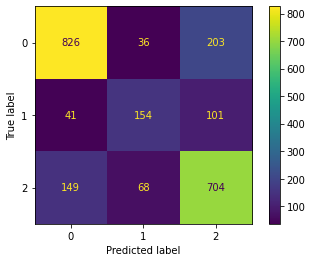

In [54]:
evaluate_model(y_true, y_pred)

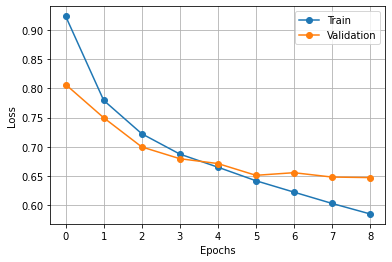

In [55]:
plot_loss_vs_epochs(train_losses, validation_losses)

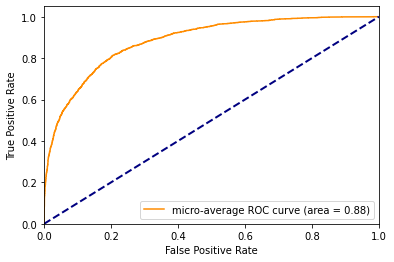

In [56]:
plot_roc_curve(y_true, scores)

## Model 2: 

Now, let's retrain with skip connections enabled:

*   cell: LSTM
*   hidden dimension: 512
*   layers: 2
*   skip connections: True
*   gradient clipping: 0.99
*   dropout: 20%







In [60]:
reset_seed()

In [61]:
model = MyRNN(CellType.LSTM, len(tweet_field.vocab), tweet_field.vocab.vectors, 300, 512, 2, dropout=0.25, skip_connections=True)
model

MyRNN(
  (embedding): Embedding(18266, 300)
  (cells_forward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
  )
  (cells_backward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)

In [62]:
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits((train_data, validation_data, test_data), batch_size=1024, sort=False, shuffle=True, device=device)

In [63]:
train_losses, validation_losses = train(model, train_iterator,validation_iterator, learning_rate=0.001, epochs=9, optimizer="Adam", clip_grad_value=0.99)

Epoch   0: Loss = 0.92307 Val_loss = 0.80650 Val_accuracy = 63.97897 F1_Score = 0.59694
Epoch   1: Loss = 0.77940 Val_loss = 0.74970 Val_accuracy = 66.12621 F1_Score = 0.63364
Epoch   2: Loss = 0.72243 Val_loss = 0.69989 Val_accuracy = 68.49255 F1_Score = 0.67364
Epoch   3: Loss = 0.68769 Val_loss = 0.67982 Val_accuracy = 69.98247 F1_Score = 0.69188
Epoch   4: Loss = 0.66532 Val_loss = 0.67153 Val_accuracy = 70.20158 F1_Score = 0.70250
Epoch   5: Loss = 0.64219 Val_loss = 0.65144 Val_accuracy = 71.86678 F1_Score = 0.71741
Epoch   6: Loss = 0.62271 Val_loss = 0.65590 Val_accuracy = 71.51621 F1_Score = 0.70202
Epoch   7: Loss = 0.60344 Val_loss = 0.64846 Val_accuracy = 72.34882 F1_Score = 0.71476
Epoch   8: Loss = 0.58551 Val_loss = 0.64755 Val_accuracy = 73.79492 F1_Score = 0.73719


In [64]:
y_pred, y_true, scores = model.predict(test_iterator)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1065
           1       0.60      0.52      0.56       296
           2       0.70      0.76      0.73       921

    accuracy                           0.74      2282
   macro avg       0.70      0.69      0.69      2282
weighted avg       0.74      0.74      0.74      2282

Precision: 0.7387190534417
Recall: 0.7379491673970202
F1 Score: 0.7371872540348149


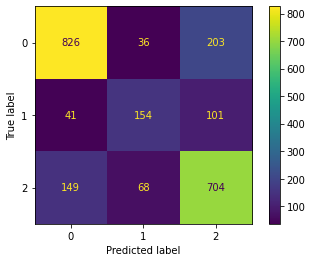

In [65]:
evaluate_model(y_true, y_pred)

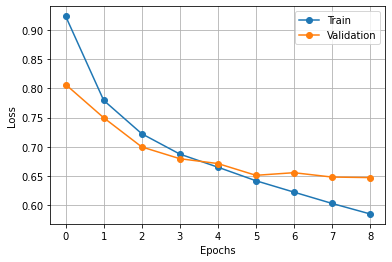

In [66]:
plot_loss_vs_epochs(train_losses, validation_losses)

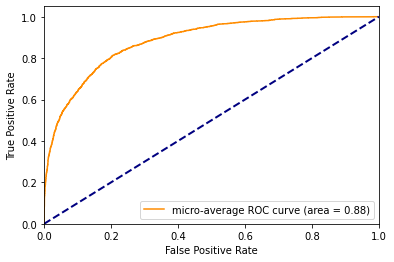

In [67]:
plot_roc_curve(y_true, scores)

As you can see, the results are still the same as without the skip connections. This may be because we only have 2 layers and we don't have much information to preserve from previous layer outputs.

## Model 3:

Let's try a different cell type (GRU):

*   cell: GRU
*   hidden dimension: 512
*   layers: 2
*   skip connections: False
*   gradient clipping: 1.0
*   dropout: 20%


In [76]:
reset_seed()

In [77]:
model = MyRNN(CellType.GRU, len(tweet_field.vocab), tweet_field.vocab.vectors, 300, 512, 2, dropout=0.2)
model

MyRNN(
  (embedding): Embedding(18266, 300)
  (cells_forward): ModuleList(
    (0): GRU(300, 512, batch_first=True)
    (1): GRU(512, 512, batch_first=True)
  )
  (cells_backward): ModuleList(
    (0): GRU(300, 512, batch_first=True)
    (1): GRU(512, 512, batch_first=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)

In [78]:
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits((train_data, validation_data, test_data), batch_size=1024, sort=False, shuffle=True, device=device)

In [79]:
train_losses, validation_losses = train(model, train_iterator,validation_iterator, learning_rate=0.001, epochs=10, optimizer="Adam", clip_grad_value=1.0)

Epoch   0: Loss = 0.87374 Val_loss = 0.76804 Val_accuracy = 64.68011 F1_Score = 0.62160
Epoch   1: Loss = 0.73559 Val_loss = 0.72192 Val_accuracy = 67.87905 F1_Score = 0.66733
Epoch   2: Loss = 0.69893 Val_loss = 0.69581 Val_accuracy = 68.79930 F1_Score = 0.68329
Epoch   3: Loss = 0.68079 Val_loss = 0.68942 Val_accuracy = 69.85101 F1_Score = 0.67980
Epoch   4: Loss = 0.65845 Val_loss = 0.66701 Val_accuracy = 70.85890 F1_Score = 0.70137
Epoch   5: Loss = 0.63284 Val_loss = 0.66062 Val_accuracy = 71.77914 F1_Score = 0.71695
Epoch   6: Loss = 0.61323 Val_loss = 0.65416 Val_accuracy = 71.99825 F1_Score = 0.71071
Epoch   7: Loss = 0.59494 Val_loss = 0.64848 Val_accuracy = 72.39264 F1_Score = 0.72068
Epoch   8: Loss = 0.57388 Val_loss = 0.66171 Val_accuracy = 72.56792 F1_Score = 0.72412
Epoch   9: Loss = 0.55373 Val_loss = 0.64899 Val_accuracy = 73.22524 F1_Score = 0.73044


In [80]:
y_pred, y_true, scores = model.predict(test_iterator)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1065
           1       0.56      0.49      0.52       296
           2       0.71      0.73      0.72       921

    accuracy                           0.73      2282
   macro avg       0.69      0.67      0.68      2282
weighted avg       0.73      0.73      0.73      2282

Precision: 0.7294818301107826
Recall: 0.7322524101665207
F1 Score: 0.7304409027763678


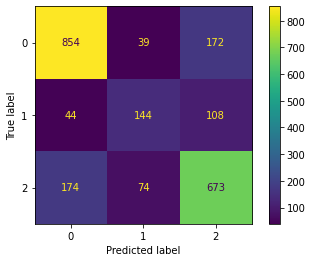

In [81]:
evaluate_model(y_true, y_pred)

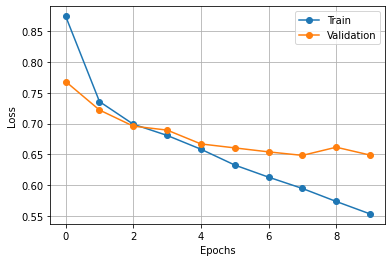

In [82]:
plot_loss_vs_epochs(train_losses, validation_losses)

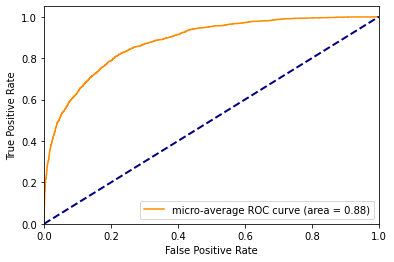

In [83]:
plot_roc_curve(y_true, scores)

Hmmmm the results are worse than the best model (Model 1) which has accuracy 73.79492% and f1 score 0.73719 . This may be because LSTM has better and more advanced mechanism to keep past info than GRU.

## Model 4:

Now, let's try with 3 layers on the best cell type (LSTM):

*   cell: LSTM
*   hidden dimension: 512
*   layers: 3
*   skip connections: *False*
*   gradient clipping: 1.0
*   dropout: 45%


In [103]:
reset_seed()

In [104]:
model = MyRNN(CellType.LSTM, len(tweet_field.vocab), tweet_field.vocab.vectors, 300, 512, 3, dropout=0.45, skip_connections=False)
model

MyRNN(
  (embedding): Embedding(18266, 300)
  (cells_forward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
    (2): LSTM(512, 512, batch_first=True)
  )
  (cells_backward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
    (2): LSTM(512, 512, batch_first=True)
  )
  (dropout): Dropout(p=0.45, inplace=False)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)

In [105]:
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits((train_data, validation_data, test_data), batch_size=1024, sort=False, shuffle=True, device=device)

In [106]:
train_losses, validation_losses = train(model, train_iterator,validation_iterator, learning_rate=0.001, epochs=15, optimizer="Adam", clip_grad_value=1.0)

Epoch   0: Loss = 0.96617 Val_loss = 0.83035 Val_accuracy = 62.92726 F1_Score = 0.58381
Epoch   1: Loss = 0.81117 Val_loss = 0.77236 Val_accuracy = 65.33742 F1_Score = 0.60924
Epoch   2: Loss = 0.75460 Val_loss = 0.72943 Val_accuracy = 67.22174 F1_Score = 0.63545
Epoch   3: Loss = 0.71669 Val_loss = 0.71441 Val_accuracy = 67.87905 F1_Score = 0.66576
Epoch   4: Loss = 0.69142 Val_loss = 0.67848 Val_accuracy = 70.68361 F1_Score = 0.70480
Epoch   5: Loss = 0.66831 Val_loss = 0.66525 Val_accuracy = 70.94654 F1_Score = 0.70636
Epoch   6: Loss = 0.64916 Val_loss = 0.65091 Val_accuracy = 71.60386 F1_Score = 0.70895
Epoch   7: Loss = 0.64687 Val_loss = 0.66193 Val_accuracy = 69.71954 F1_Score = 0.69127
Epoch   8: Loss = 0.62891 Val_loss = 0.64465 Val_accuracy = 72.52410 F1_Score = 0.72576
Epoch   9: Loss = 0.61181 Val_loss = 0.64013 Val_accuracy = 71.91060 F1_Score = 0.71567
Epoch  10: Loss = 0.59541 Val_loss = 0.65009 Val_accuracy = 72.30500 F1_Score = 0.72619
Epoch  11: Loss = 0.58558 Val_lo

In [107]:
y_pred, y_true, scores = model.predict(test_iterator)

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1065
           1       0.55      0.52      0.53       296
           2       0.69      0.78      0.73       921

    accuracy                           0.73      2282
   macro avg       0.69      0.68      0.68      2282
weighted avg       0.74      0.73      0.73      2282

Precision: 0.7374740710643297
Recall: 0.7322524101665207
F1 Score: 0.7328258726058826


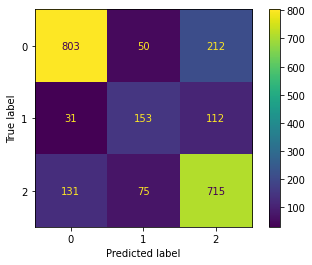

In [108]:
evaluate_model(y_true, y_pred)

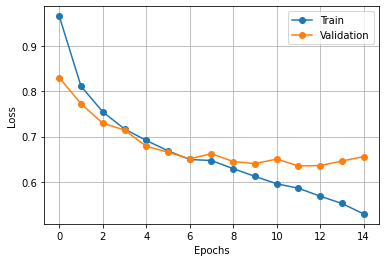

In [109]:
plot_loss_vs_epochs(train_losses, validation_losses)

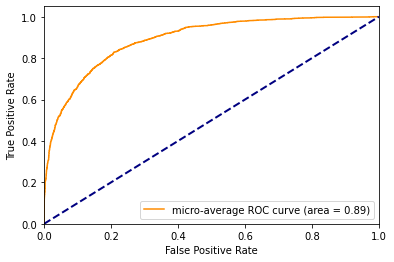

In [110]:
plot_roc_curve(y_true, scores)

As you can see the results did not improve from our best model. This may be because of the degradation problem which appears when we increase the number of hidden layers. So, we will try to train the same model but this time with skip connections enabled.

## Model 5:

Same as the previous one but this time with skip connections enabled:

*   cell: LSTM
*   hidden dimension: 512
*   layers: 3
*   skip connections: True
*   gradient clipping: 1.0
*   dropout: 45%


In [84]:
reset_seed()

In [85]:
model = MyRNN(CellType.LSTM, len(tweet_field.vocab), tweet_field.vocab.vectors, 300, 512, 3, dropout=0.45, skip_connections=True)
model

MyRNN(
  (embedding): Embedding(18266, 300)
  (cells_forward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
    (2): LSTM(512, 512, batch_first=True)
  )
  (cells_backward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
    (2): LSTM(512, 512, batch_first=True)
  )
  (dropout): Dropout(p=0.45, inplace=False)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)

In [86]:
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits((train_data, validation_data, test_data), batch_size=1024, sort=False, shuffle=True, device=device)

In [87]:
train_losses, validation_losses = train(model, train_iterator,validation_iterator, learning_rate=0.001, epochs=15, optimizer="Adam", clip_grad_value=1.0)

Epoch   0: Loss = 0.93563 Val_loss = 0.80102 Val_accuracy = 64.06661 F1_Score = 0.59855
Epoch   1: Loss = 0.78186 Val_loss = 0.74810 Val_accuracy = 66.73970 F1_Score = 0.66599
Epoch   2: Loss = 0.73354 Val_loss = 0.70692 Val_accuracy = 68.40491 F1_Score = 0.68545
Epoch   3: Loss = 0.70869 Val_loss = 0.69745 Val_accuracy = 69.85101 F1_Score = 0.69531
Epoch   4: Loss = 0.68804 Val_loss = 0.68498 Val_accuracy = 68.62401 F1_Score = 0.68741
Epoch   5: Loss = 0.66164 Val_loss = 0.65943 Val_accuracy = 71.51621 F1_Score = 0.70618
Epoch   6: Loss = 0.64406 Val_loss = 0.65403 Val_accuracy = 71.25329 F1_Score = 0.70767
Epoch   7: Loss = 0.63240 Val_loss = 0.65216 Val_accuracy = 71.03418 F1_Score = 0.70594
Epoch   8: Loss = 0.61937 Val_loss = 0.63993 Val_accuracy = 72.83085 F1_Score = 0.72726
Epoch   9: Loss = 0.60046 Val_loss = 0.63912 Val_accuracy = 72.91849 F1_Score = 0.72784
Epoch  10: Loss = 0.58418 Val_loss = 0.66331 Val_accuracy = 71.69150 F1_Score = 0.72150
Epoch  11: Loss = 0.57788 Val_lo

In [88]:
y_pred, y_true, scores = model.predict(test_iterator)

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1065
           1       0.53      0.57      0.55       296
           2       0.70      0.78      0.74       921

    accuracy                           0.73      2282
   macro avg       0.69      0.70      0.69      2282
weighted avg       0.74      0.73      0.74      2282

Precision: 0.7447112419018108
Recall: 0.7344434706397897
F1 Score: 0.7368484454455432


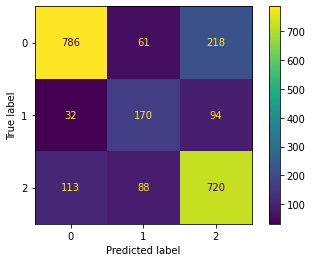

In [89]:
evaluate_model(y_true, y_pred)

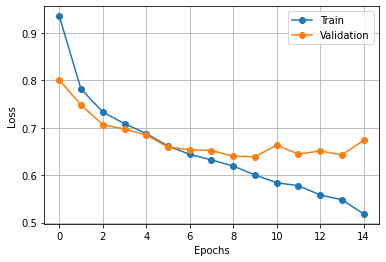

In [90]:
plot_loss_vs_epochs(train_losses, validation_losses)

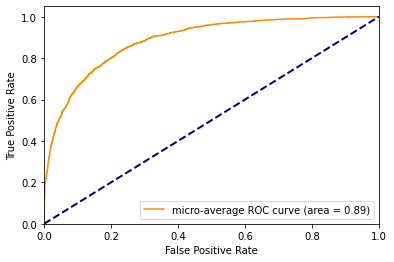

In [91]:
plot_roc_curve(y_true, scores)

As you can see, the results are much better than without the skip connections enabled which was expected.

So to conclude, our best model is **Model 1** with accuracy 73.79492% and F1_Score 0.73719.

# Adding Attention

We will now retrain our best Model (Model 1) but this time with a self-attention layer on the rnn final outputs. For the self attention, i used multihead attention like in the transformers model from the paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) to add attention context to the rnn outputs and for the calculation of the text vector i took the weighted sum of the rnn output vectors and their corresponding attention layer outputs. As you will see, from this technique, i got an improvement on both accuracy and f1 score.

## Model 1:

*   cell: LSTM
*   hidden dimension: 512
*   layers: 2
*   skip connections: False
*   gradient clipping: 0.99
*   dropout: 20%

In [64]:
reset_seed()

In [65]:
model = MyRNN(CellType.LSTM, len(tweet_field.vocab), tweet_field.vocab.vectors, 300, 512, 2, dropout=0.25, skip_connections=False, attention=True)
model

MyRNN(
  (embedding): Embedding(18266, 300)
  (cells_forward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
  )
  (cells_backward): ModuleList(
    (0): LSTM(300, 512, batch_first=True)
    (1): LSTM(512, 512, batch_first=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (W_Q_att): Linear(in_features=1024, out_features=1024, bias=False)
  (W_K_att): Linear(in_features=1024, out_features=1024, bias=False)
  (W_V_att): Linear(in_features=1024, out_features=1024, bias=False)
  (mh_att): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
  )
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)

In [66]:
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits((train_data, validation_data, test_data), batch_size=1024, sort=False, shuffle=True, device=device)

In [67]:
train_losses, validation_losses = train(model, train_iterator,validation_iterator, learning_rate=0.001, epochs=11, optimizer="Adam", clip_grad_value=0.99)

Epoch   0: Loss = 0.94879 Val_loss = 0.80007 Val_accuracy = 64.94303 F1_Score = 0.60478
Epoch   1: Loss = 0.76572 Val_loss = 0.73023 Val_accuracy = 67.30938 F1_Score = 0.63461
Epoch   2: Loss = 0.71203 Val_loss = 0.69222 Val_accuracy = 69.80719 F1_Score = 0.68013
Epoch   3: Loss = 0.69198 Val_loss = 0.69513 Val_accuracy = 69.80719 F1_Score = 0.68764
Epoch   4: Loss = 0.67217 Val_loss = 0.66245 Val_accuracy = 71.07800 F1_Score = 0.70605
Epoch   5: Loss = 0.64148 Val_loss = 0.64646 Val_accuracy = 72.52410 F1_Score = 0.72102
Epoch   6: Loss = 0.62080 Val_loss = 0.64638 Val_accuracy = 71.86678 F1_Score = 0.71541
Epoch   7: Loss = 0.61527 Val_loss = 0.65195 Val_accuracy = 71.77914 F1_Score = 0.71417
Epoch   8: Loss = 0.59577 Val_loss = 0.64170 Val_accuracy = 72.30500 F1_Score = 0.71827
Epoch   9: Loss = 0.58394 Val_loss = 0.63075 Val_accuracy = 72.78703 F1_Score = 0.72256
Epoch  10: Loss = 0.56118 Val_loss = 0.63648 Val_accuracy = 73.88256 F1_Score = 0.73920


In [45]:
y_pred, y_true, scores = model.predict(test_iterator)

              precision    recall  f1-score   support

           0       0.84      0.75      0.80      1065
           1       0.57      0.52      0.55       296
           2       0.69      0.79      0.74       921

    accuracy                           0.74      2282
   macro avg       0.70      0.69      0.69      2282
weighted avg       0.74      0.74      0.74      2282

Precision: 0.7448391138333071
Recall: 0.7388255915863278
F1 Score: 0.7391981829840351


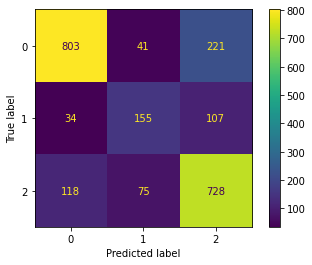

In [46]:
evaluate_model(y_true, y_pred)

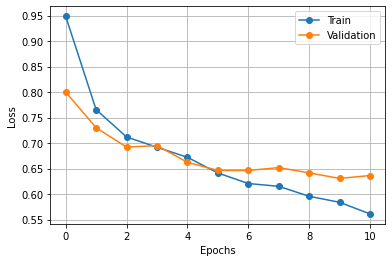

In [47]:
plot_loss_vs_epochs(train_losses, validation_losses)

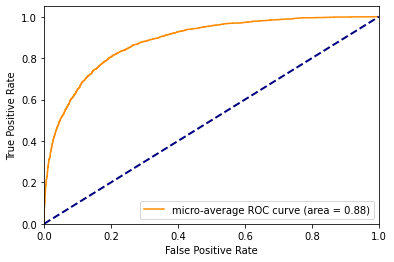

In [48]:
plot_roc_curve(y_true, scores)

As you can see, we got 9% improvement in the accuracy of the best model and some improvement on the f1 score. Note that i tried different kind of attentions (basic dot product, multiplicative, additive) but this is the one that improved the accuracy of my best model (the other ones gave worse results).